In [5]:
!pip install pyswarms
!pip install niapy --pre


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Rohit Nigam\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Rohit Nigam\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc,f1_score
import torch.nn as nn
from torchvision import models, transforms
import pandas as pd
import matplotlib.pyplot as plt
from niapy.problems import Problem
from niapy.task import Task
from niapy.algorithms.basic import ParticleSwarmOptimization
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

In [7]:
data_dir = '../input/leukemia/Original'
data_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

images = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        image_path = os.path.join(foldpath, file)
        image = Image.open(image_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        image = data_transforms(image)
        images.append(image)
        labels.append(fold)

X = np.stack(images)
y = labels

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../input/leukemia/Original'

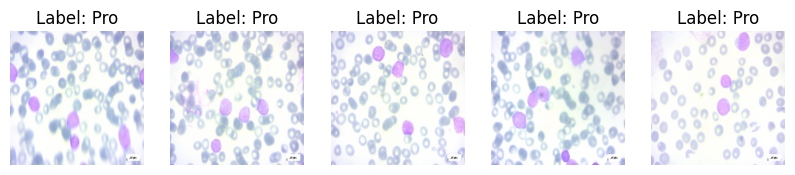

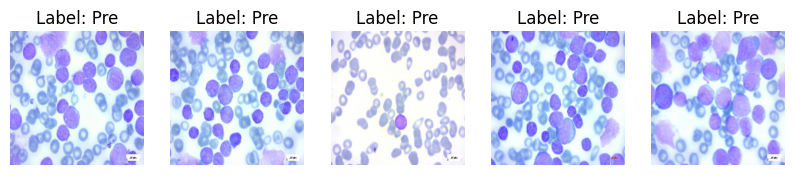

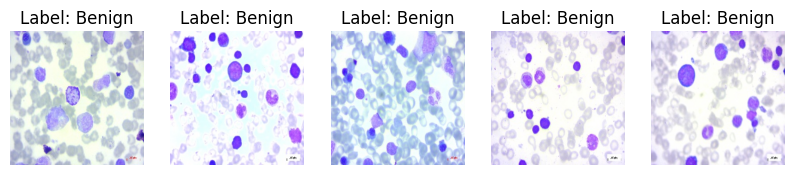

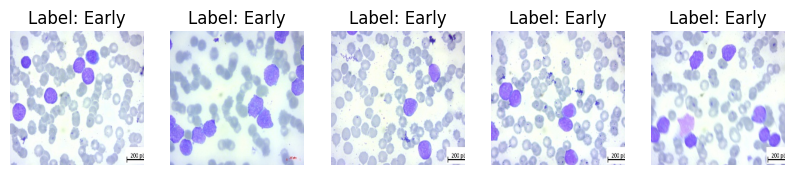

In [ ]:
folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    plt.figure(figsize=(10, 5))
    i = 0
    for file in filelist[:5]:
        image_path = os.path.join(foldpath, file)
        image = Image.open(image_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(image)  
        plt.title(f"Label: {fold}")
        plt.axis('off')
        i = i+1
    plt.show()
       

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)
np.unique(y)

array([0, 1, 2, 3])

In [ ]:
# Function to convert NumPy array to PyTorch tensor
from torch.autograd import Variable
def to_tensor(images):
    return torch.from_numpy(images).permute(0, 1, 2,3).float()

resnet50 = models.resnet50(pretrained=True)
modules=list(resnet50.children())[:-1]
resnet50=nn.Sequential(*modules)
for p in resnet50.parameters():
    p.requires_grad = False
features = []
images_tensor = to_tensor(X)
for image in images_tensor:
    image = image.unsqueeze(0)
    feature = resnet50(image)
    feature = feature.squeeze()
    features.append(feature.detach().numpy())
features = np.array(features)

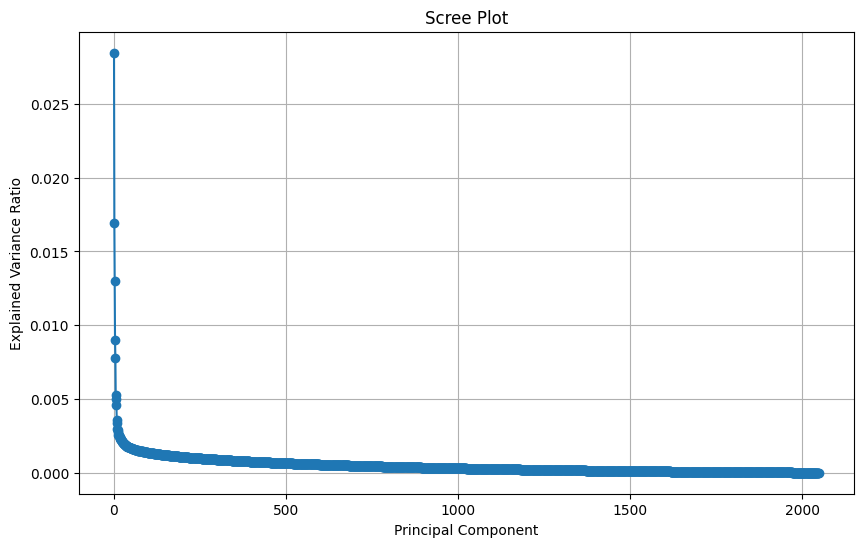

In [ ]:
pca = PCA()
pca.fit(features)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

In [ ]:
n_components = [10,100,500,1000]  
pca = {}
features_pca = {}
for n in n_components:
    pca[n] = PCA(n_components=n)
    features_pca[n] = pca[n].fit_transform(features)

In [ ]:
#np.save('features.npy', features)
features = np.load("/kaggle/input/resnet-features/features.npy")
features.shape
selected_features=np.load("/kaggle/input/pso-features/pso_features.npy")

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


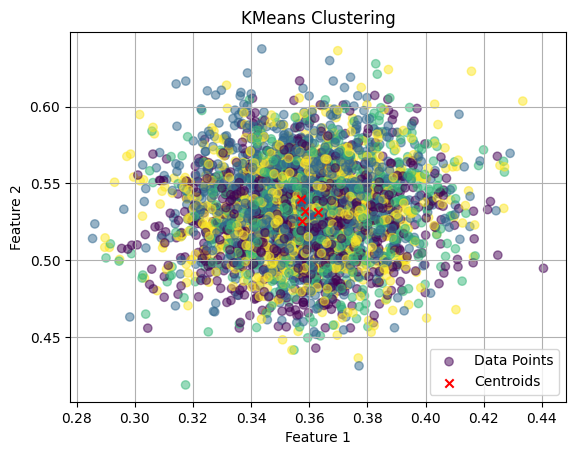

Cluster Labels: [0 1 0 ... 0 0 2]
Centroids:
 [[0.35766622 0.5257105  0.46410432 ... 0.33161125 0.43891495 0.32043207]
 [0.35721767 0.53988975 0.47000983 ... 0.33080012 0.444867   0.32753623]
 [0.36319706 0.53146183 0.46188596 ... 0.33202207 0.44099444 0.32664376]
 [0.35851866 0.5320541  0.4589704  ... 0.3306038  0.4417792  0.31905016]]


In [ ]:
n_clusters = 4
# Initialize KMeans model
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(features)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis', alpha=0.5, label='Data Points')

# Scatter plot of the cluster centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', label='Centroids')

plt.title('KMeans Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()
# Print the cluster labels and centroids
print("Cluster Labels:", labels)
print("Centroids:\n", centroids)

In [ ]:
class SVMFeatureSelection(Problem):
    def __init__(self, X_train, y_train, alpha=0.99):
        super().__init__(dimension=X_train.shape[1], lower=0, upper=1)
        self.X_train = X_train
        self.y_train = y_train
        self.alpha = alpha

    def _evaluate(self, x):
        selected = x > 0.5
        num_selected = selected.sum()
        if num_selected == 0:
            return 1.0
        accuracy = cross_val_score(SVC(), self.X_train[:, selected], self.y_train, cv=2, n_jobs=-1).mean()
        score = 1 - accuracy
        num_features = self.X_train.shape[1]
        return self.alpha * score + (1 - self.alpha) * (num_selected / num_features)
problem = SVMFeatureSelection(features, y)
task = Task(problem, max_iters=10)
algorithm = ParticleSwarmOptimization(population_size=20, seed=1234)
best_features, best_fitness = algorithm.run(task)
selected_features = best_features > 0.5
print('Number of selected features:', selected_features.sum())

Number of selected features: 1047


In [ ]:
selected_features

array([ True, False,  True, ..., False,  True, False])

In [ ]:
features_pca

{10: array([[-0.12872037, -0.14708005, -0.1064874 , ..., -0.01483307,
         -0.04987152,  0.05792426],
        [-0.29888567,  0.0324139 ,  0.00153142, ..., -0.05612328,
         -0.12707044, -0.10380548],
        [-0.18793483, -0.21668434,  0.02395791, ...,  0.03455777,
         -0.00423294,  0.00212677],
        ...,
        [-0.12811257, -0.08223296, -0.39045337, ..., -0.01903451,
         -0.00359796, -0.06341464],
        [-0.12378601, -0.19525279, -0.13698457, ...,  0.02697999,
          0.14408863, -0.14857101],
        [ 0.24278048,  0.08848326,  0.11171763, ..., -0.02955949,
          0.09457471, -0.12412375]], dtype=float32),
 100: array([[-0.12871988, -0.14707907, -0.10648737, ..., -0.02530063,
         -0.014111  , -0.01773308],
        [-0.29888564,  0.03241391,  0.00153241, ..., -0.03463776,
         -0.00122226, -0.03583836],
        [-0.18793447, -0.21668504,  0.02395738, ...,  0.0499957 ,
         -0.00731588,  0.08929267],
        ...,
        [-0.1281124 , -0.08223

In [ ]:
np.save("pso_features.npy",selected_features)

In [ ]:
features_pso = features[:,selected_features]

In [ ]:
features_pso.shape

(3256, 1047)

In [ ]:
def metrics(y_test,y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, cmap='Greens')
    plt.colorbar()
    plt.xticks(np.arange(4), np.arange(4))
    plt.yticks(np.arange(4), np.arange(4))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
    plt.show()
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"F1 score (macro): {f1:.2f}")

In [ ]:
def plot_roc_curve(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(np.unique(y_test))

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score[:, i], pos_label=1)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    colors = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
X_train = {}
X_test = {}
y_train = {}
y_test = {}
for n in n_components:
    X_train[n], X_test[n], y_train[n], y_test[n] = train_test_split(features_pca[n], y, test_size=0.2, random_state=42)
X_train_pso,X_test_pso,y_train_pso,y_test_pso = train_test_split(features_pso, y, test_size=0.2, random_state=42)

Accuracy: 0.69
Confusion Matrix:
[[ 23  38   4  25]
 [ 17 134  15  19]
 [  5  22 159   1]
 [ 17  35   7 131]]


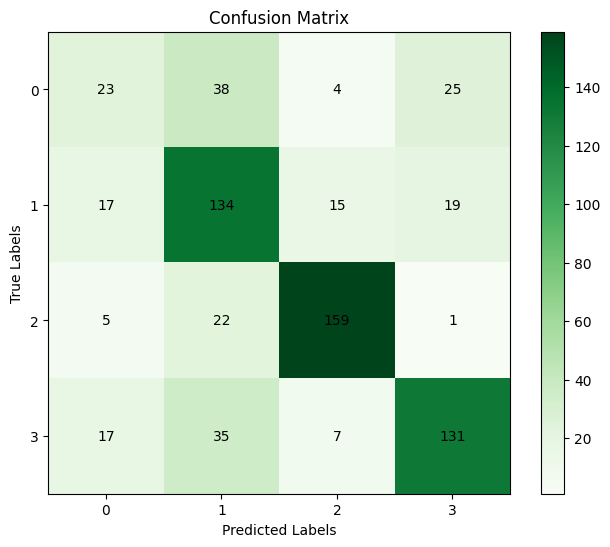

F1 score (macro): 0.63


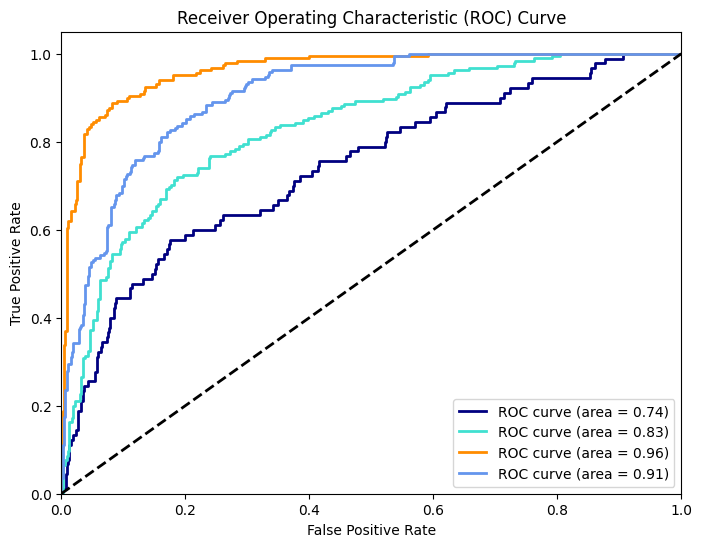

Accuracy: 0.79
Confusion Matrix:
[[ 46  30   6   8]
 [ 14 151  12   8]
 [  3  19 165   0]
 [  7  24   7 152]]


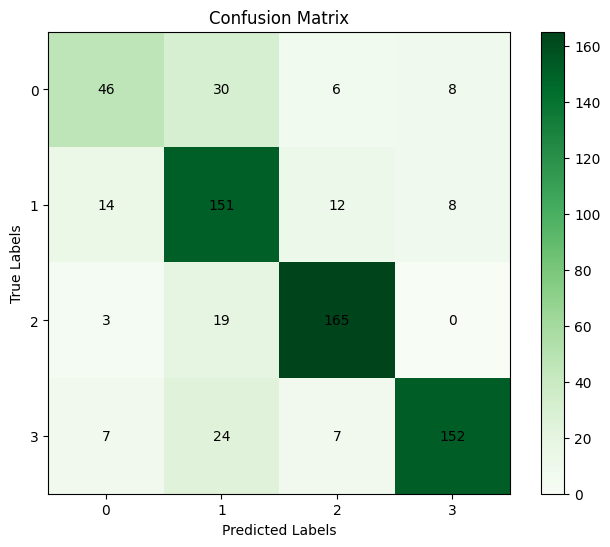

F1 score (macro): 0.76


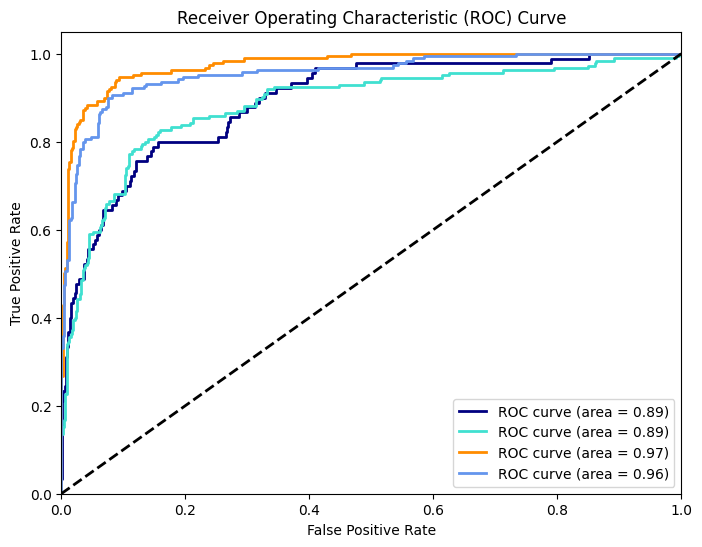

Accuracy: 0.80
Confusion Matrix:
[[ 41  33   8   8]
 [  8 157  13   7]
 [  3  14 170   0]
 [  2  27   7 154]]


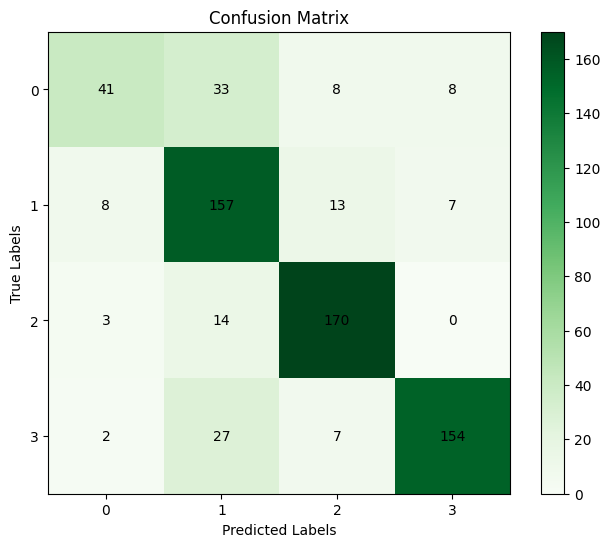

F1 score (macro): 0.77


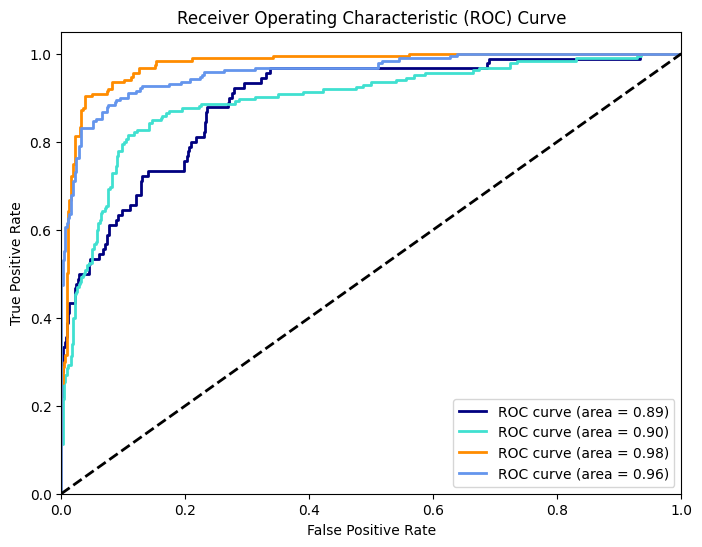

Accuracy: 0.79
Confusion Matrix:
[[ 37  37   6  10]
 [  8 157  13   7]
 [  2  15 170   0]
 [  3  28   8 151]]


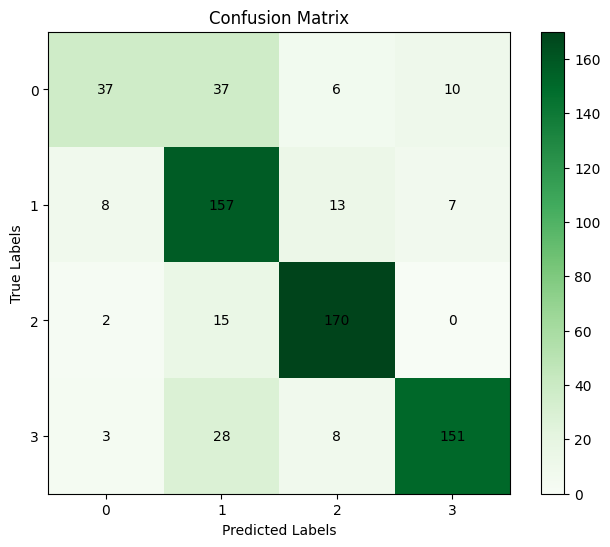

F1 score (macro): 0.75


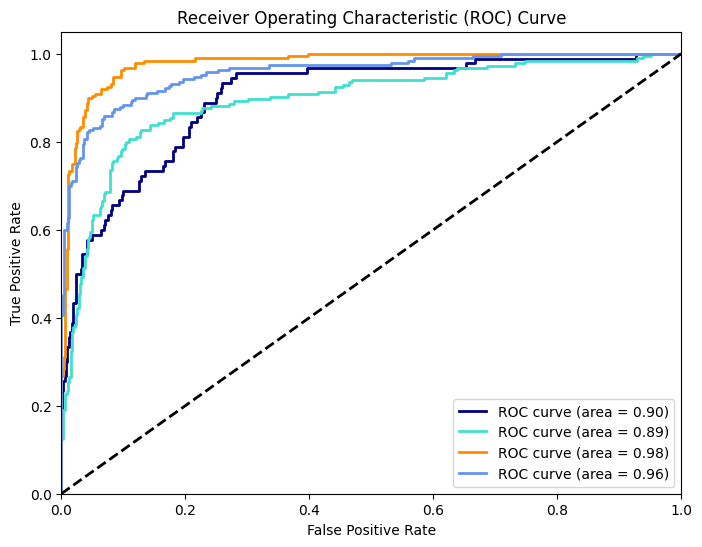

In [ ]:
for n in n_components:
    svm = SVC(kernel='rbf', C=1, decision_function_shape='ovr')
    svm.fit(X_train[n], y_train[n])
    y_pred = svm.predict(X_test[n])
    metrics(y_test[n],y_pred)
    y_score = svm.decision_function(X_test[n])
    plot_roc_curve(y_test[n],y_score)

Accuracy: 0.74
Confusion Matrix:
[[ 43  34   4   9]
 [ 10 140  23  12]
 [  4  14 164   5]
 [ 10  29  13 138]]


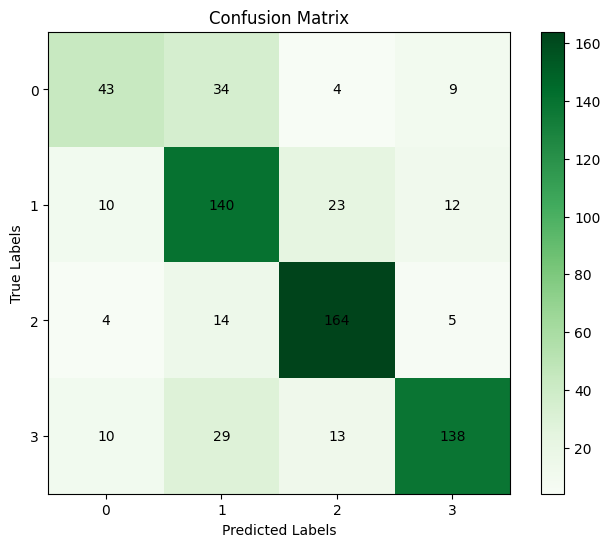

F1 score (macro): 0.72


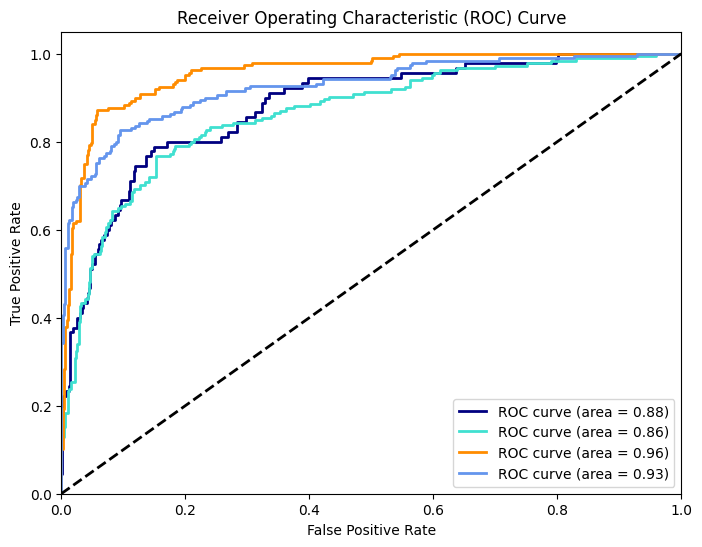

In [ ]:
svm = SVC(kernel='rbf', C=5, decision_function_shape='ovr')
svm.fit(X_train_pso, y_train_pso)
y_pred = svm.predict(X_test_pso)
metrics(y_test_pso,y_pred)
y_score = svm.decision_function(X_test_pso)
plot_roc_curve(y_test_pso,y_score)


Accuracy: 0.53
Confusion Matrix:
[[ 19  35  10  26]
 [ 36  99  27  23]
 [ 13  29 139   6]
 [ 39  42  20  89]]


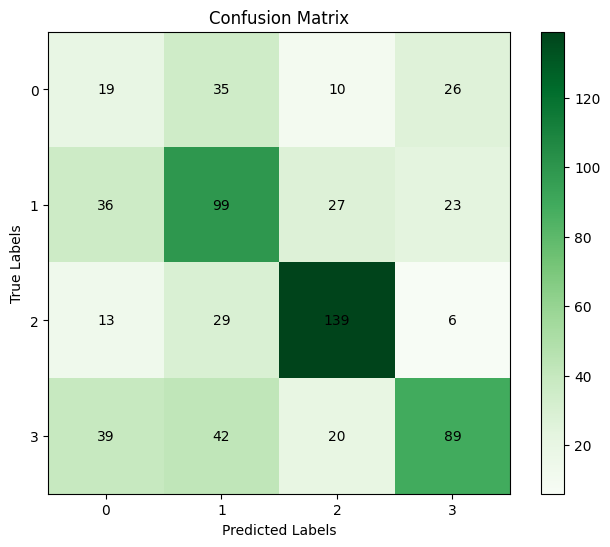

F1 score (macro): 0.49


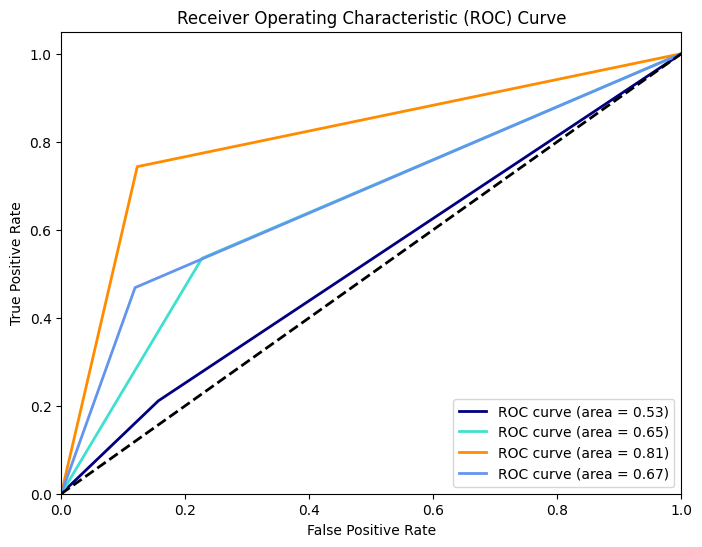

Accuracy: 0.53
Confusion Matrix:
[[ 32  28  10  20]
 [ 27  90  43  25]
 [ 17  32 126  12]
 [ 31  41  18 100]]


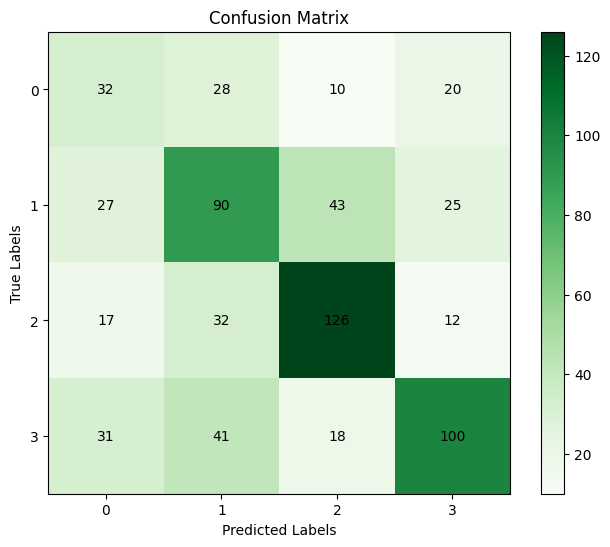

F1 score (macro): 0.51


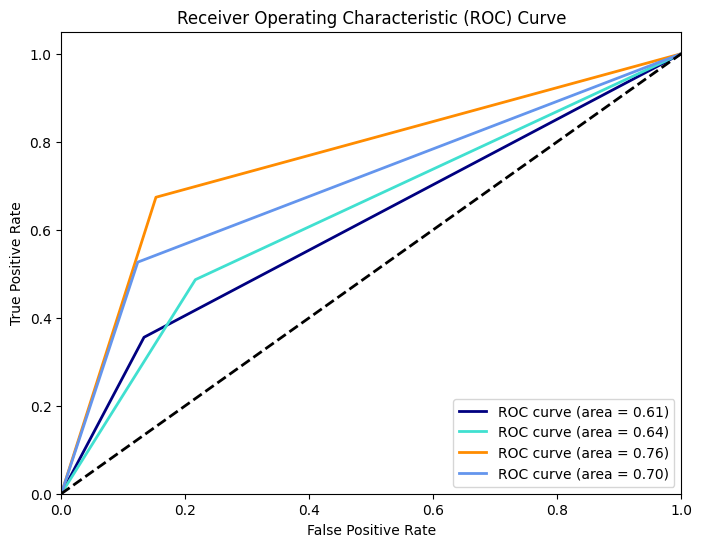

Accuracy: 0.50
Confusion Matrix:
[[ 21  28  20  21]
 [ 33  85  31  36]
 [ 16  30 126  15]
 [ 28  36  33  93]]


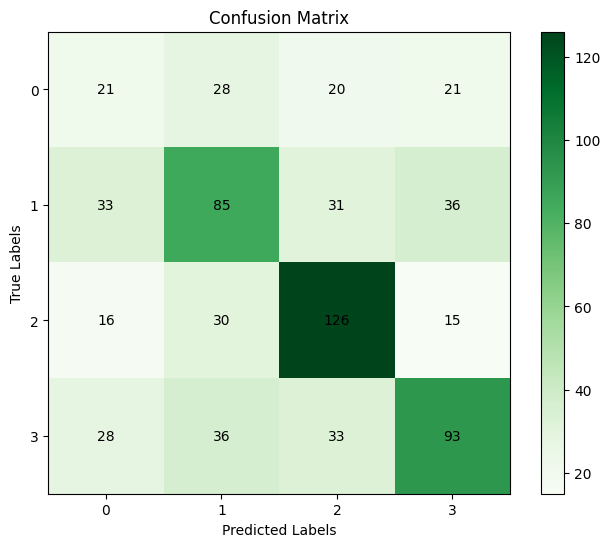

F1 score (macro): 0.46


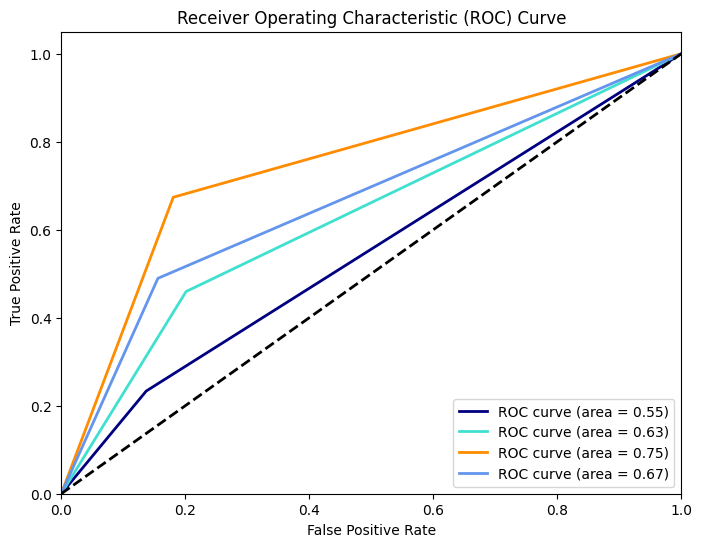

Accuracy: 0.49
Confusion Matrix:
[[ 24  26  15  25]
 [ 31  91  35  28]
 [ 17  30 118  22]
 [ 38  42  22  88]]


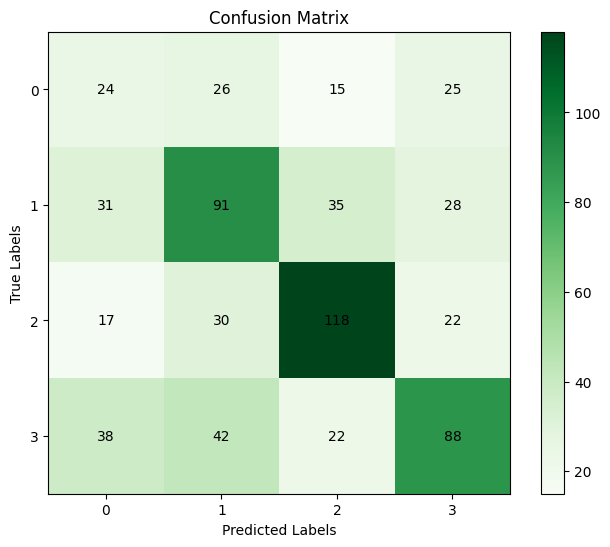

F1 score (macro): 0.46


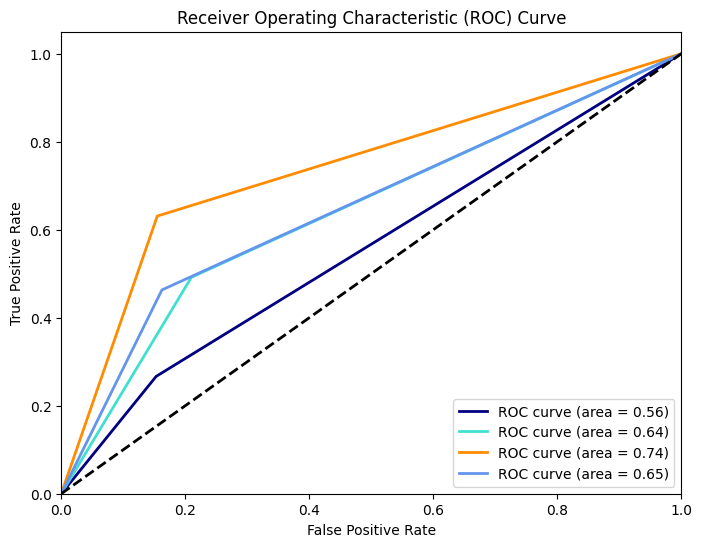

In [ ]:
for n in n_components:
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train[n], y_train[n])
    y_pred = dt.predict(X_test[n])
    y_score = dt.predict_proba(X_test[n])
    metrics(y_test[n],y_pred)
    plot_roc_curve(y_test[n],y_score)
    
    

Accuracy: 0.37
Confusion Matrix:
[[ 18  28  19  25]
 [ 32  67  32  54]
 [ 21  40 100  26]
 [ 31  65  38  56]]


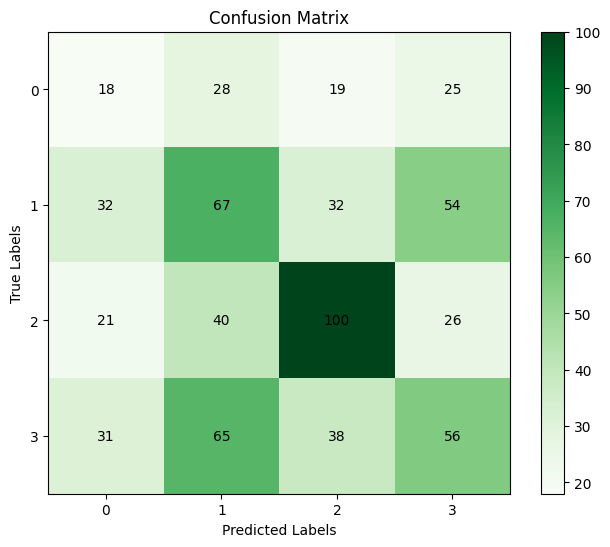

F1 score (macro): 0.35


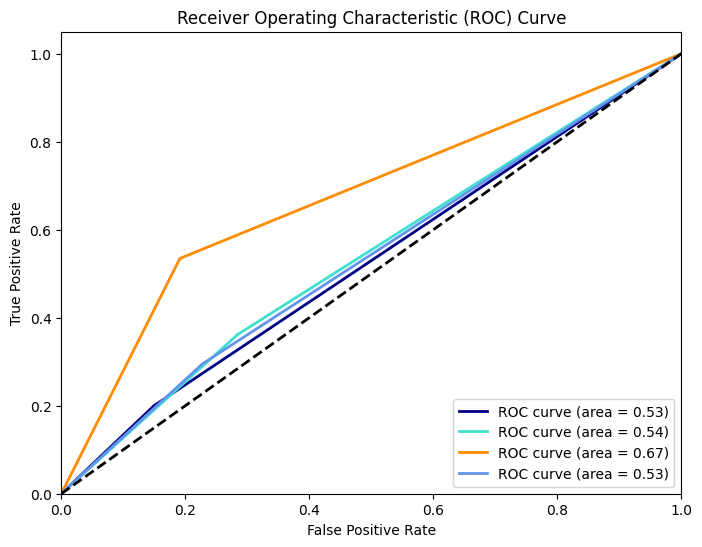

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_pso, y_train_pso)
y_pred = dt.predict(X_test_pso)
y_score = dt.predict_proba(X_test_pso)
metrics(y_test_pso,y_pred)
plot_roc_curve(y_test_pso,y_score)

Accuracy: 0.65
Confusion Matrix:
[[ 12  49   4  25]
 [ 13 129  23  20]
 [  5  22 158   2]
 [ 18  39  11 122]]


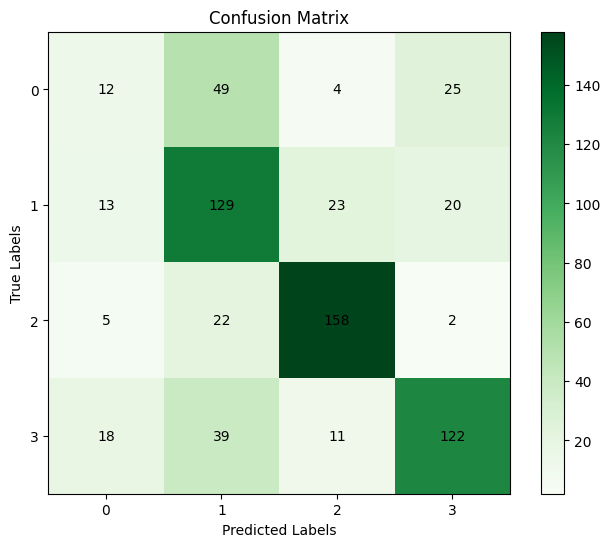

F1 score (macro): 0.57


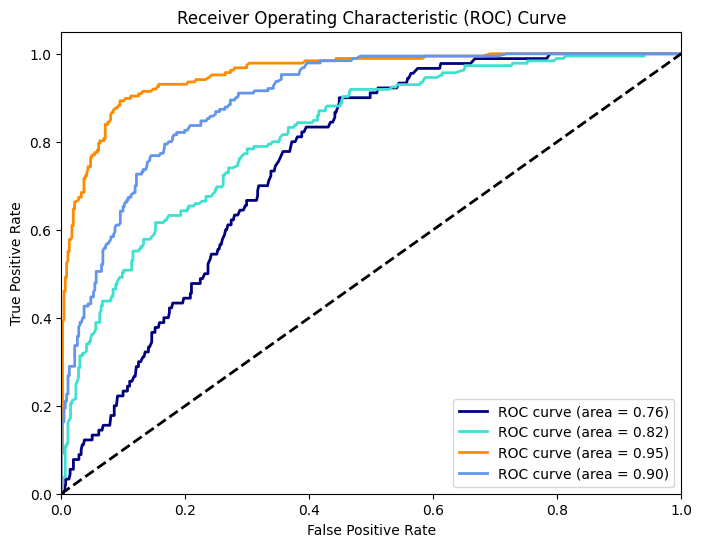

Accuracy: 0.71
Confusion Matrix:
[[  9  54  11  16]
 [  2 152  20  11]
 [  1  20 164   2]
 [  0  37  13 140]]


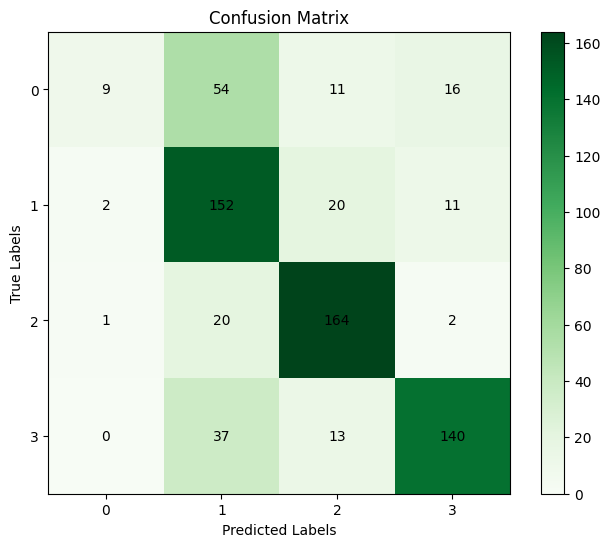

F1 score (macro): 0.62


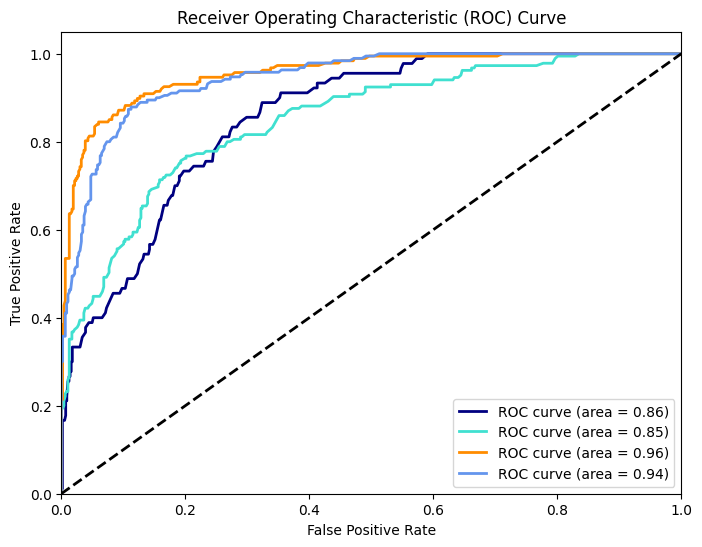

Accuracy: 0.64
Confusion Matrix:
[[  0  70  12   8]
 [  0 152  26   7]
 [  0  23 163   1]
 [  0  69  17 104]]


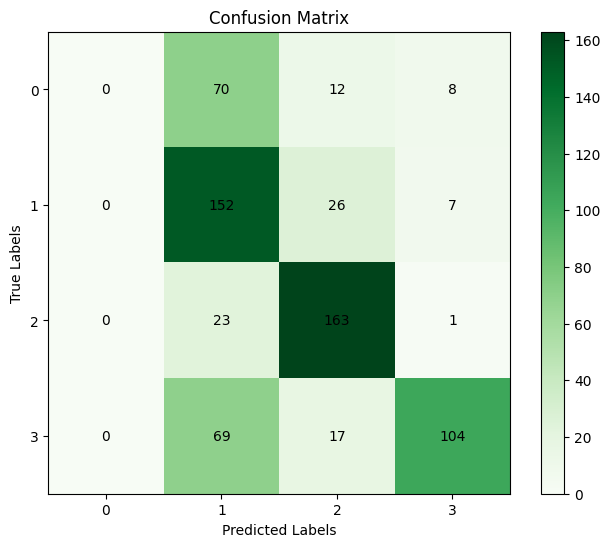

F1 score (macro): 0.52


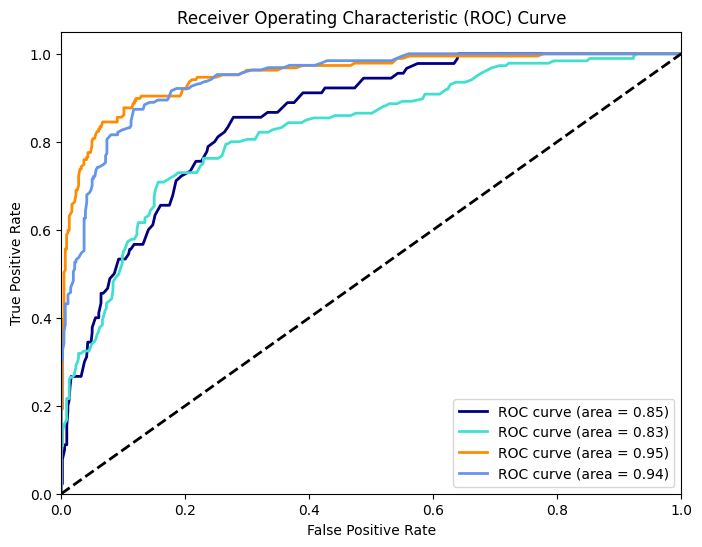

Accuracy: 0.59
Confusion Matrix:
[[  0  60  23   7]
 [  0 154  29   2]
 [  0  28 159   0]
 [  0  89  27  74]]


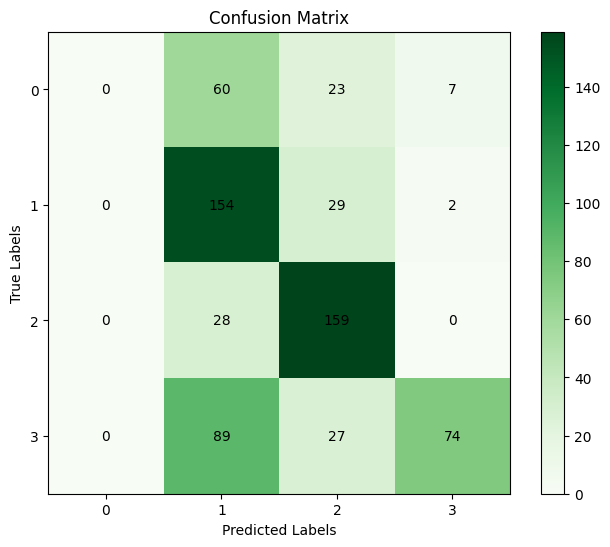

F1 score (macro): 0.47


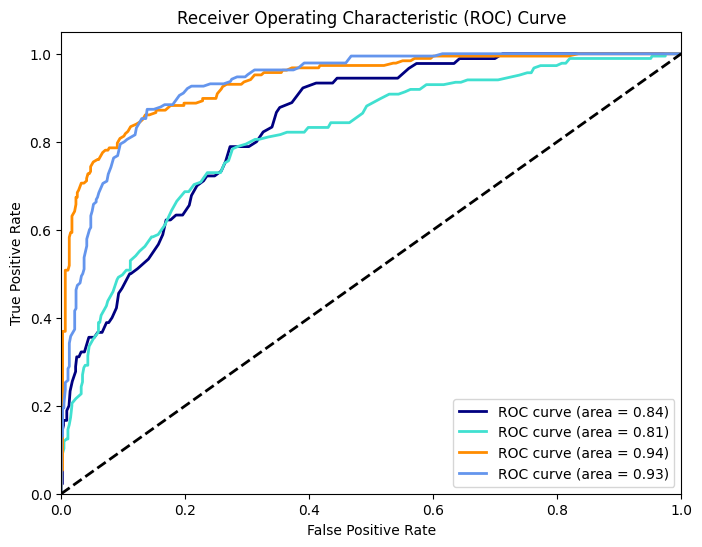

In [ ]:
for n in n_components:
    rf = RandomForestClassifier(n_estimators=1000, random_state=42)
    rf.fit(X_train[n], y_train[n])
    y_pred = rf.predict(X_test[n])
    y_score = rf.predict_proba(X_test[n])
    metrics(y_test[n],y_pred)
    plot_roc_curve(y_test[n],y_score)
    

Accuracy: 0.59
Confusion Matrix:
[[  0  70  16   4]
 [  0 149  32   4]
 [  0  28 159   0]
 [  0  97  17  76]]


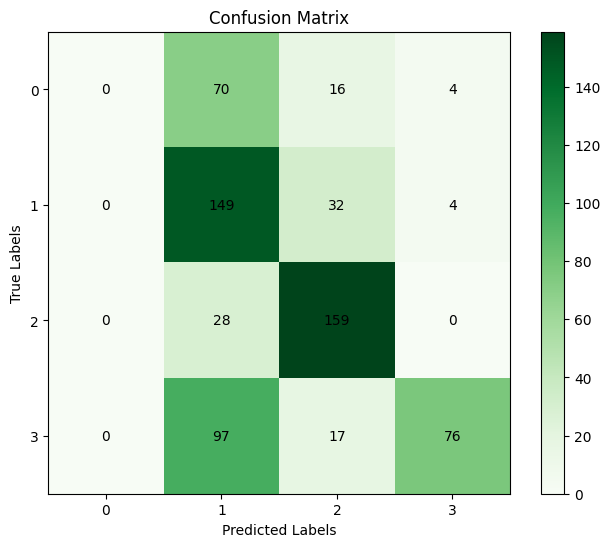

F1 score (macro): 0.47


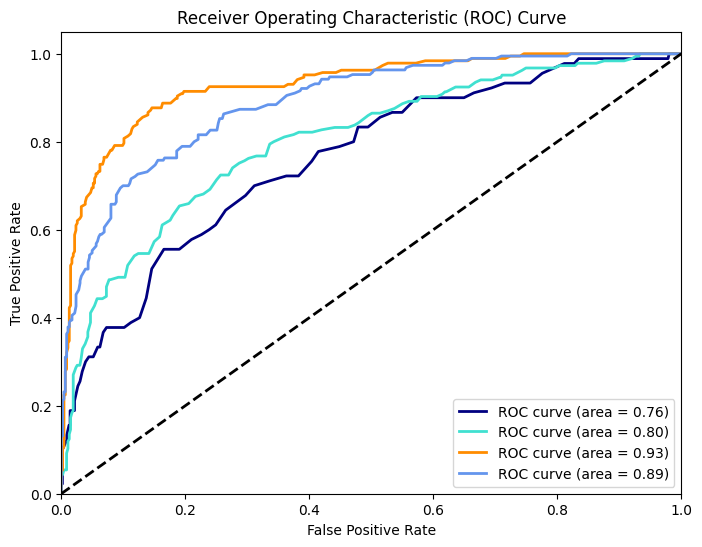

In [ ]:
rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train_pso, y_train_pso)
y_pred = rf.predict(X_test_pso)
y_score = rf.predict_proba(X_test_pso)
metrics(y_test_pso,y_pred)
plot_roc_curve(y_test_pso,y_score)

Accuracy: 0.65
Confusion Matrix:
[[ 24  34   6  26]
 [ 19 116  28  22]
 [  7  18 160   2]
 [ 25  33   9 123]]


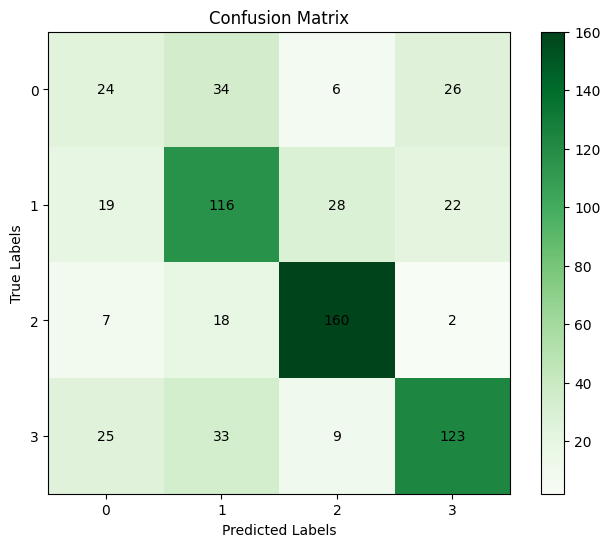

F1 score (macro): 0.60


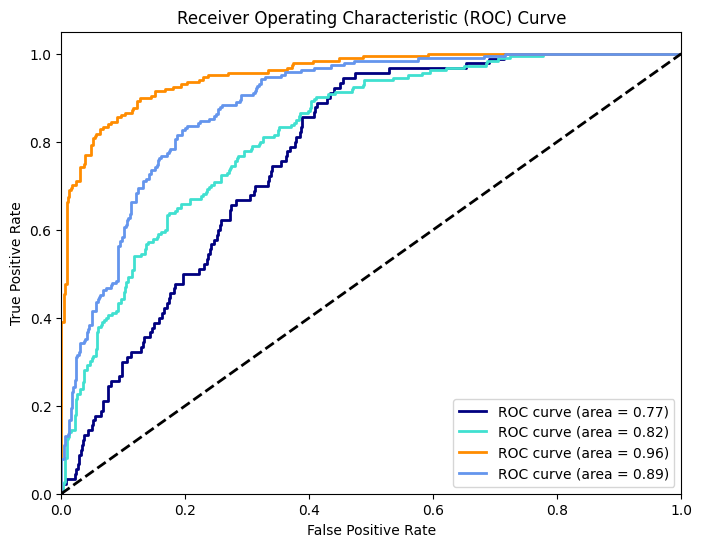

Accuracy: 0.74
Confusion Matrix:
[[ 42  29   6  13]
 [ 16 137  21  11]
 [  6  19 161   1]
 [  5  28  12 145]]


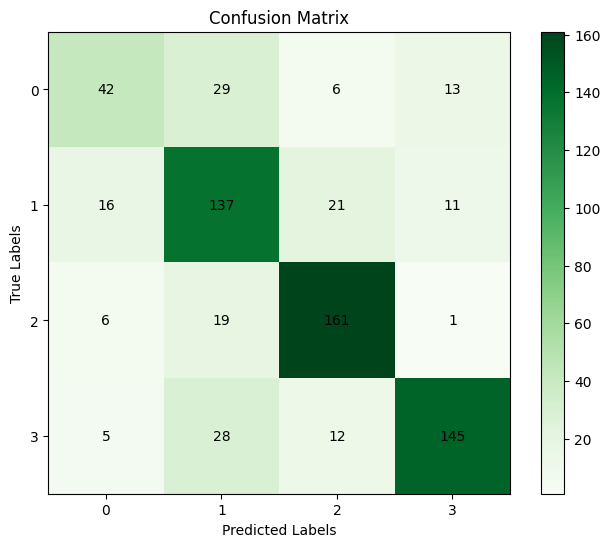

F1 score (macro): 0.71


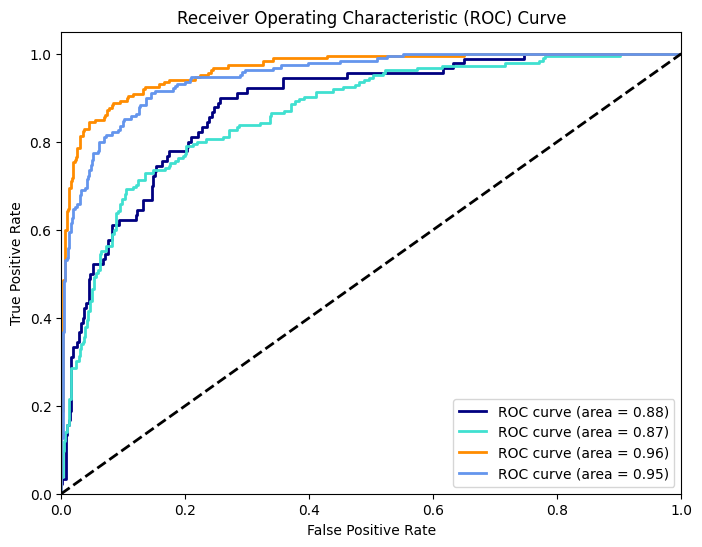

Accuracy: 0.74
Confusion Matrix:
[[ 30  41   6  13]
 [ 13 142  17  13]
 [  6  14 165   2]
 [  6  24  13 147]]


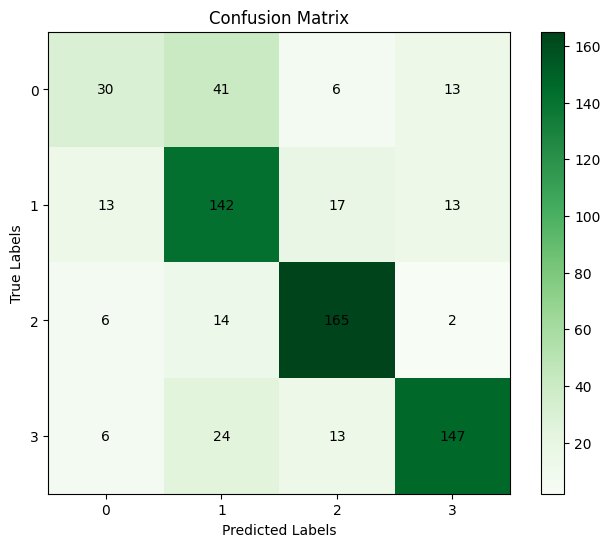

F1 score (macro): 0.69


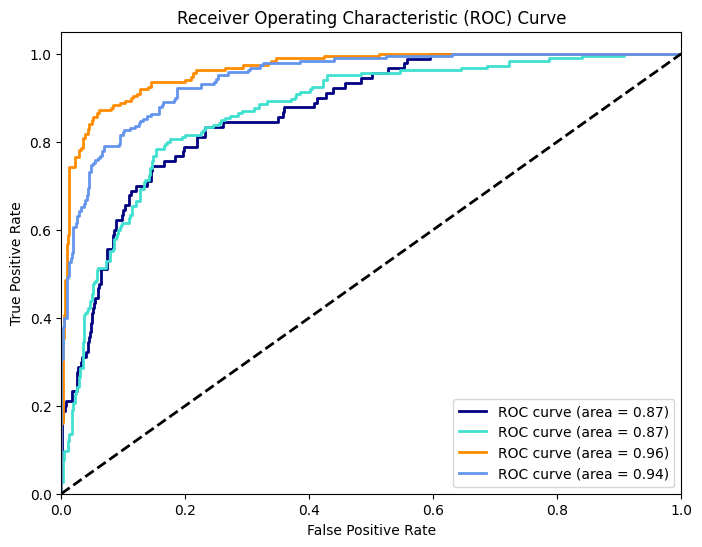

Accuracy: 0.73
Confusion Matrix:
[[ 32  34   6  18]
 [ 14 136  20  15]
 [  6  15 162   4]
 [ 10  26  11 143]]


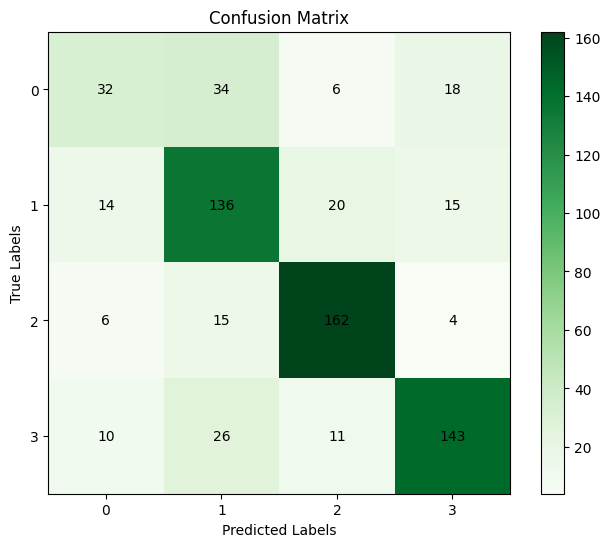

F1 score (macro): 0.68


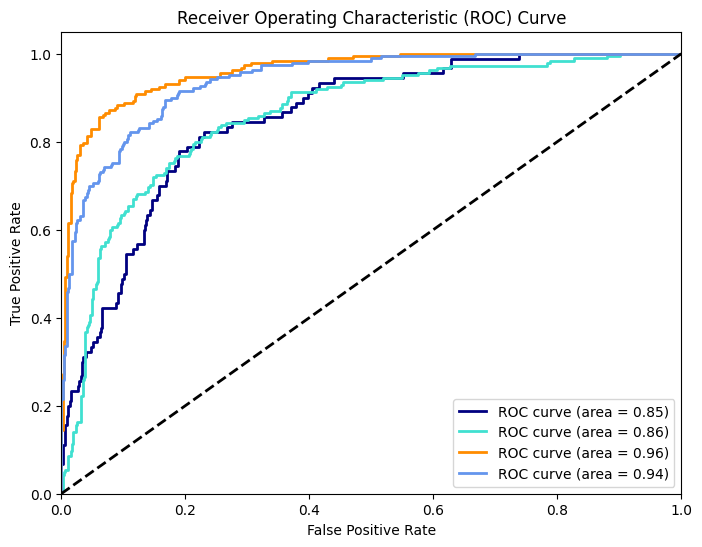

In [ ]:
for n in n_components:
    xgb = XGBClassifier(objective='multi:softprob', n_estimators=100, random_state=42)
    xgb.fit(X_train[n], y_train[n])
    y_pred = xgb.predict(X_test[n])
    y_score = xgb.predict_proba(X_test[n])
    metrics(y_test[n],y_pred)
    plot_roc_curve(y_test[n],y_score)

Accuracy: 0.67
Confusion Matrix:
[[ 18  45  15  12]
 [  6 140  29  10]
 [  1  28 156   2]
 [  6  38  23 123]]


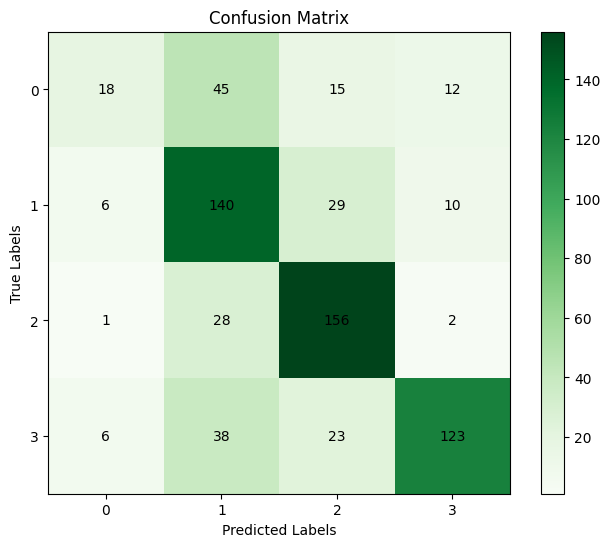

F1 score (macro): 0.61


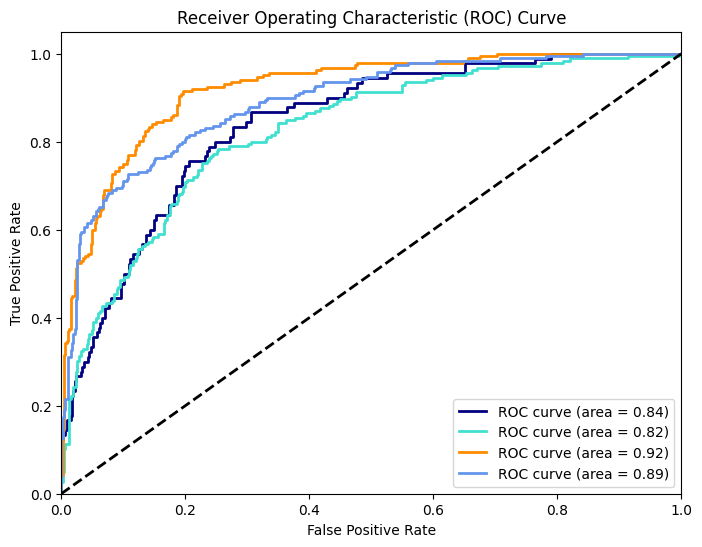

In [ ]:
xgb = XGBClassifier(objective='multi:softprob', n_estimators=100, random_state=42)
xgb.fit(X_train_pso, y_train_pso)
y_pred = xgb.predict(X_test_pso)
y_score = xgb.predict_proba(X_test_pso)
metrics(y_test_pso,y_pred)
plot_roc_curve(y_test_pso,y_score)

Accuracy: 0.62
Confusion Matrix:
[[ 20  42   9  19]
 [ 24 120  16  25]
 [  5  25 154   3]
 [ 27  38  17 108]]


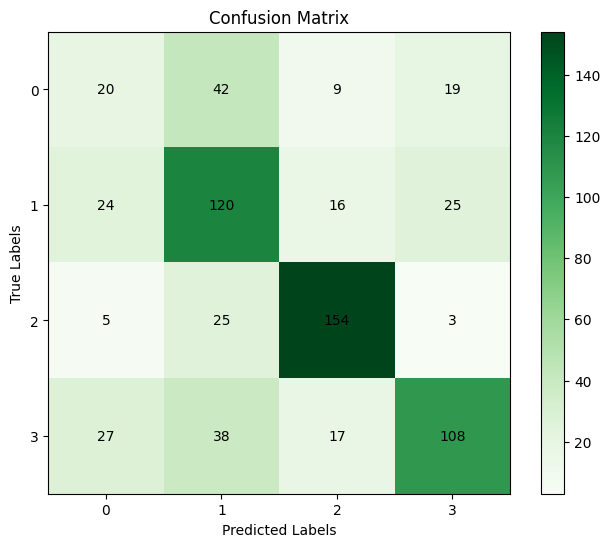

F1 score (macro): 0.56


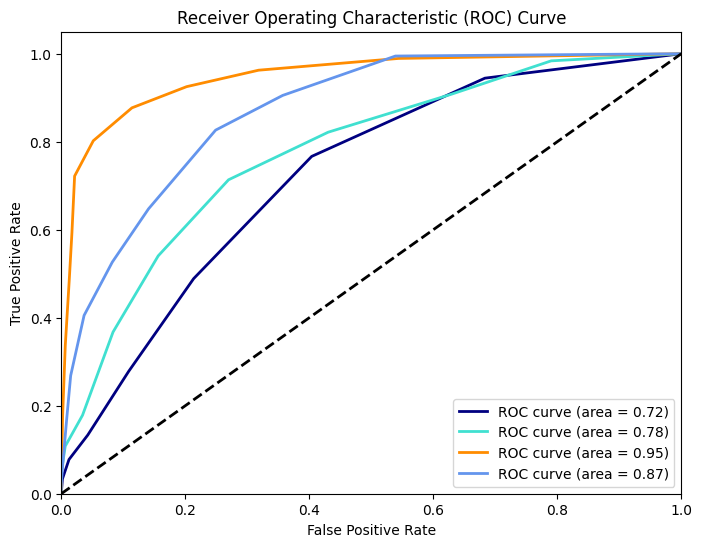

Accuracy: 0.66
Confusion Matrix:
[[ 29  32  14  15]
 [ 17 125  28  15]
 [  4  21 161   1]
 [ 16  39  18 117]]


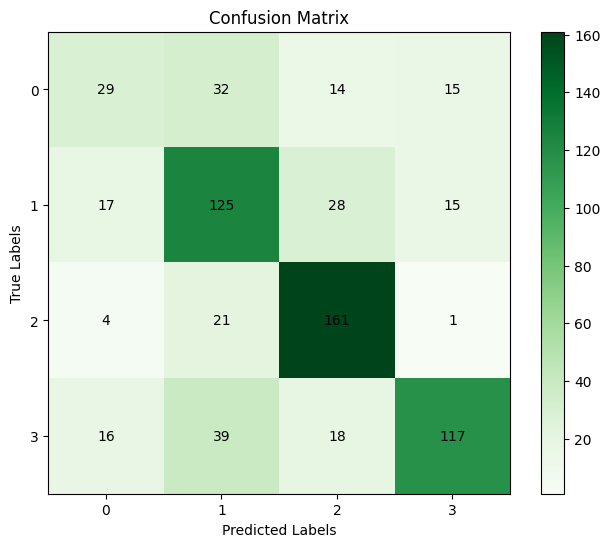

F1 score (macro): 0.62


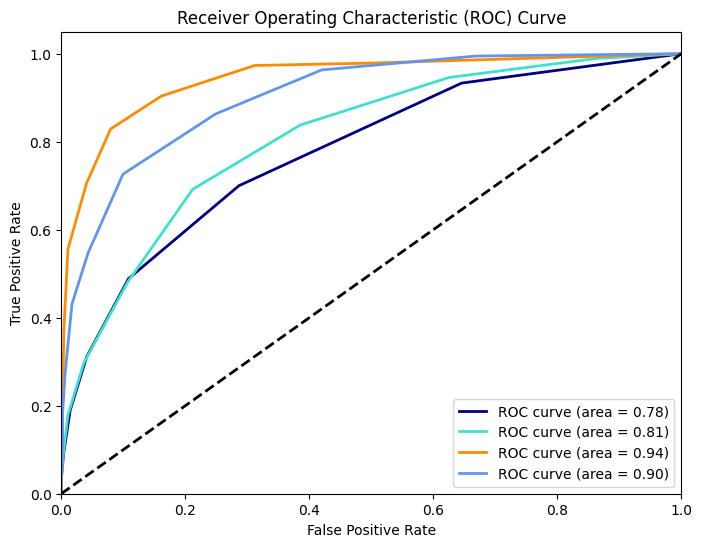

Accuracy: 0.68
Confusion Matrix:
[[ 33  31  10  16]
 [ 12 126  23  24]
 [  3  31 146   7]
 [  6  33  15 136]]


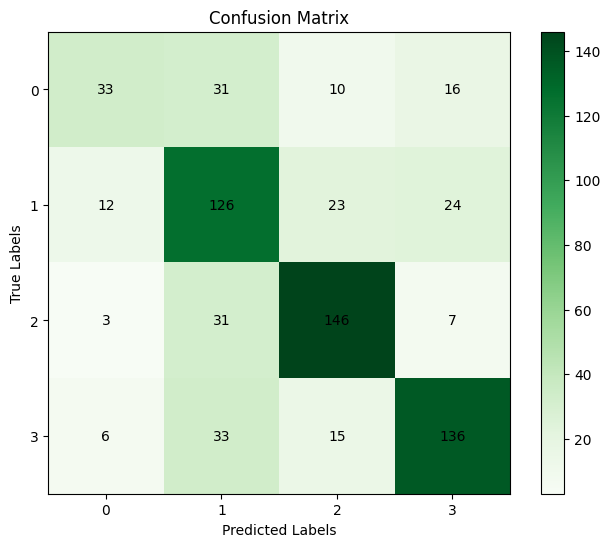

F1 score (macro): 0.64


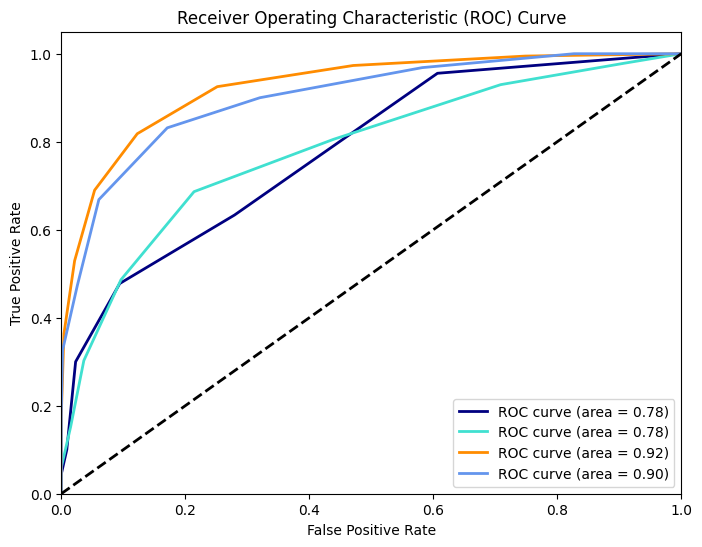

Accuracy: 0.65
Confusion Matrix:
[[ 26  35  14  15]
 [ 15 124  19  27]
 [  3  35 140   9]
 [  6  36  14 134]]


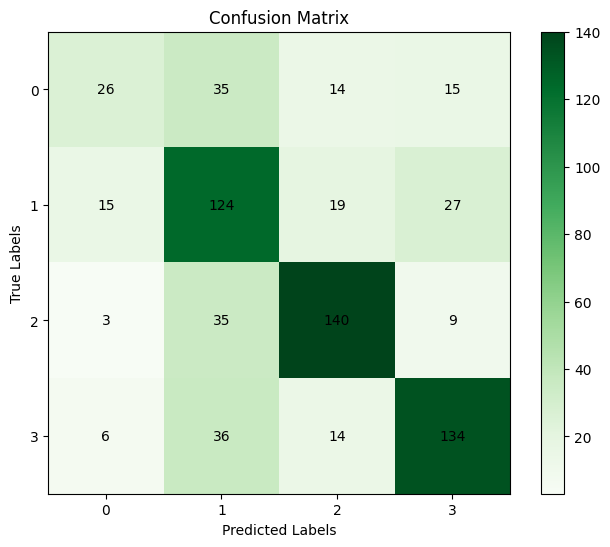

F1 score (macro): 0.61


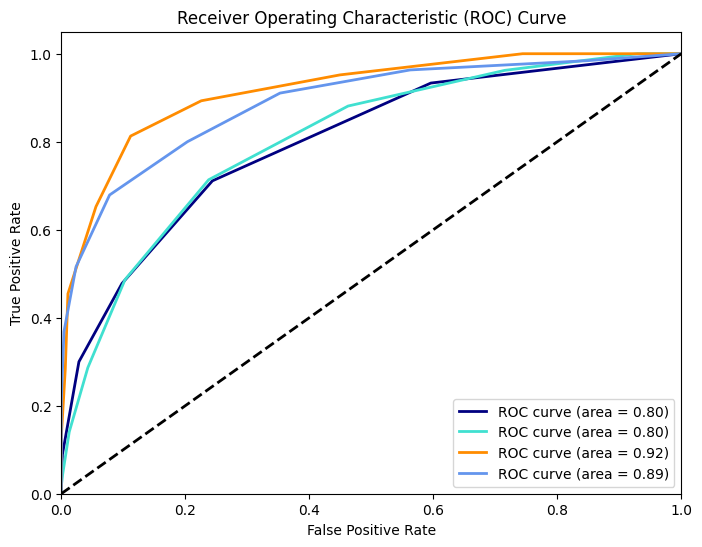

In [ ]:
for n in n_components:
    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(X_train[n], y_train[n])
    y_pred = knn.predict(X_test[n])
    y_score = knn.predict_proba(X_test[n])
    metrics(y_test[n],y_pred)
    plot_roc_curve(y_test[n],y_score)

Accuracy: 0.62
Confusion Matrix:
[[ 27  38  10  15]
 [ 12 126  24  23]
 [  3  36 141   7]
 [ 14  57  11 108]]


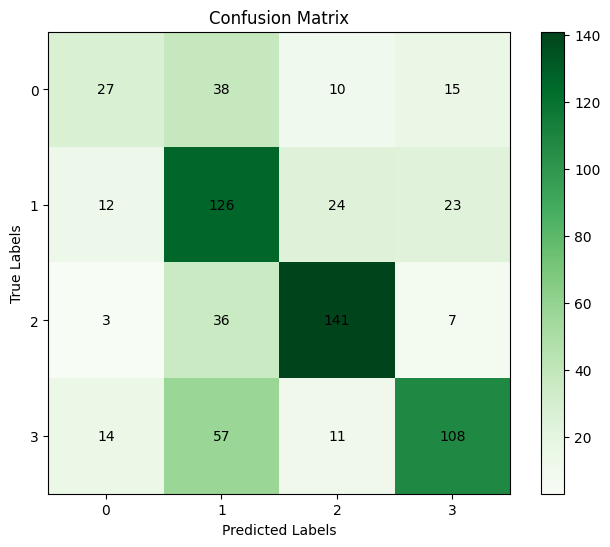

F1 score (macro): 0.58


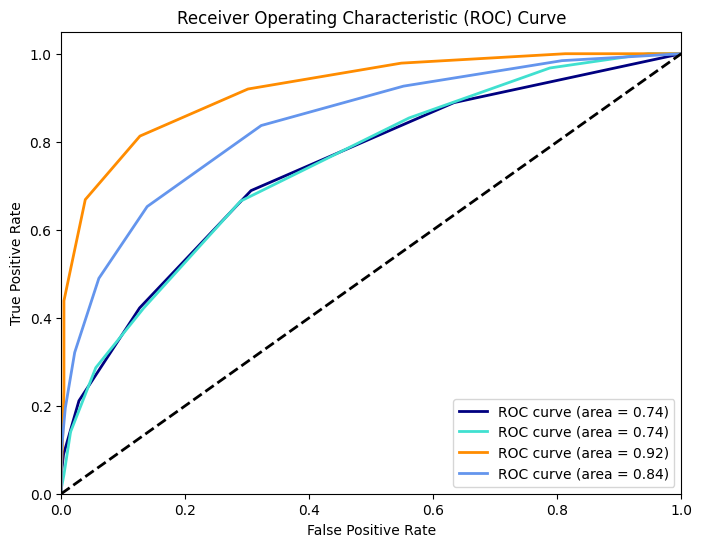

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_pso, y_train_pso)
y_pred = knn.predict(X_test_pso)
y_score = knn.predict_proba(X_test_pso)
metrics(y_test_pso,y_pred)
plot_roc_curve(y_test_pso,y_score)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.64
Confusion Matrix:
[[  1  63   8  18]
 [  0 144  30  11]
 [  0  24 163   0]
 [  0  75   8 107]]


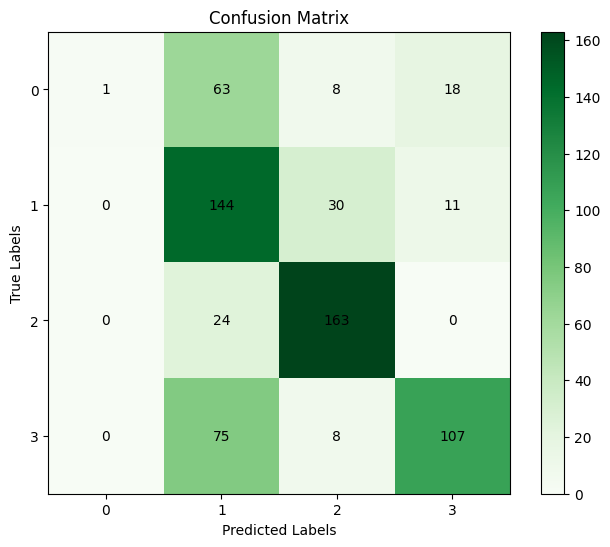

F1 score (macro): 0.52


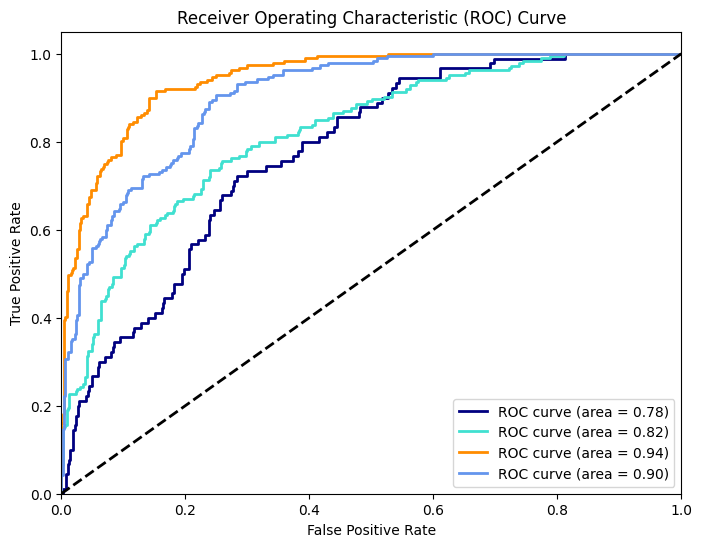

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.76
Confusion Matrix:
[[ 40  37   4   9]
 [  9 143  27   6]
 [  2  14 171   0]
 [  5  36   8 141]]


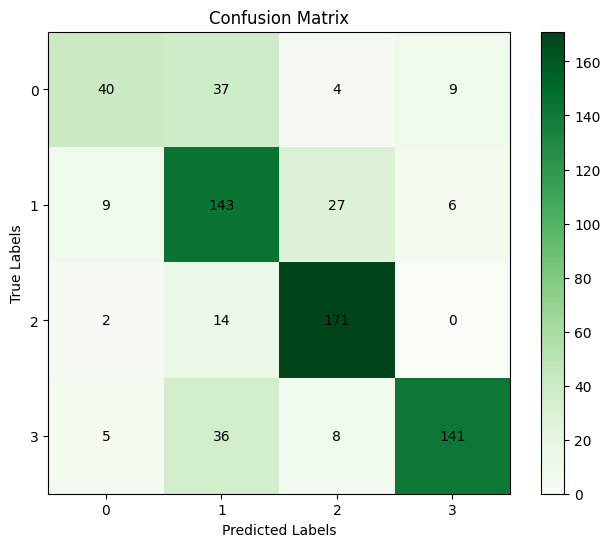

F1 score (macro): 0.73


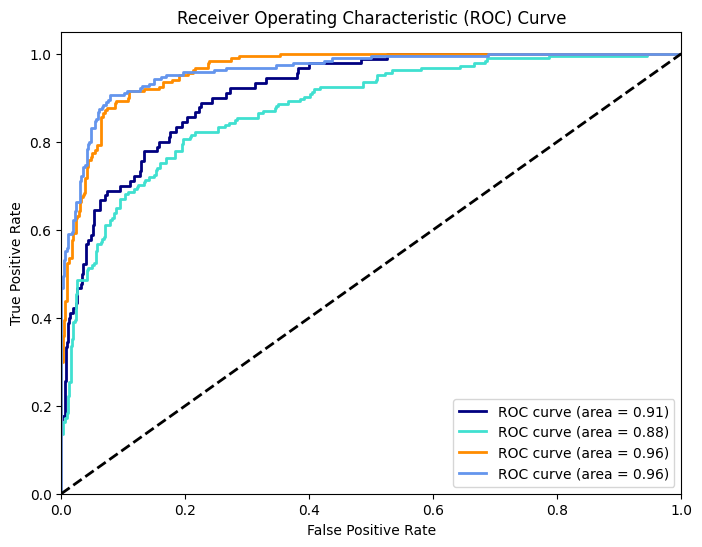

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.75
Confusion Matrix:
[[ 59  20   6   5]
 [ 37 127  17   4]
 [ 14  15 158   0]
 [ 20  20   5 145]]


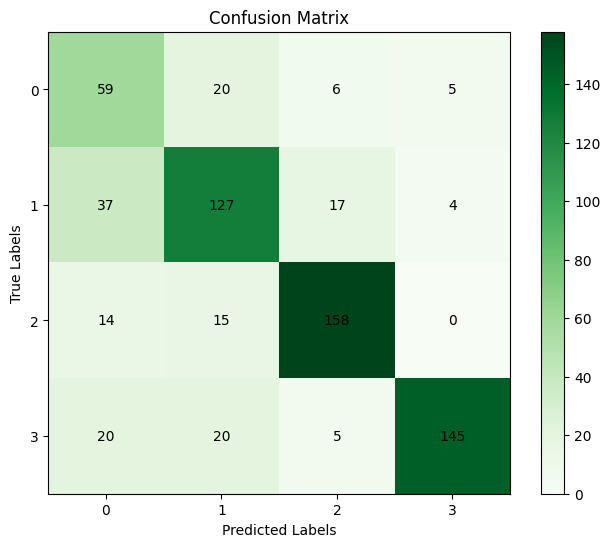

F1 score (macro): 0.73


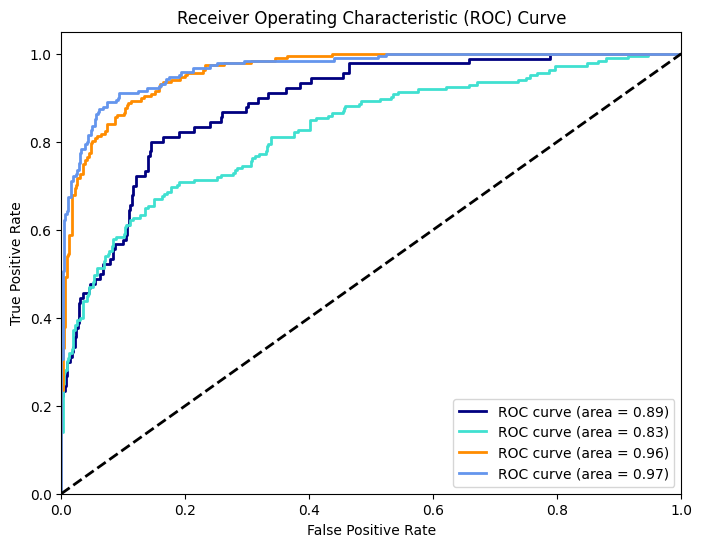

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.63
Confusion Matrix:
[[ 63  26   1   0]
 [ 39 129  13   4]
 [ 31  20 135   1]
 [ 51  45   9  85]]


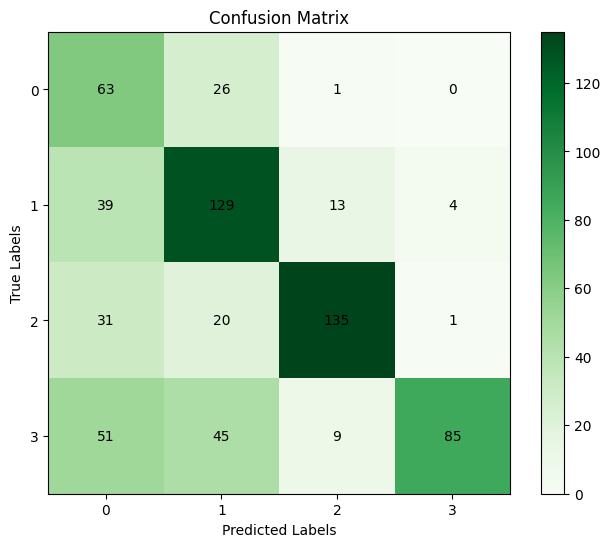

F1 score (macro): 0.62


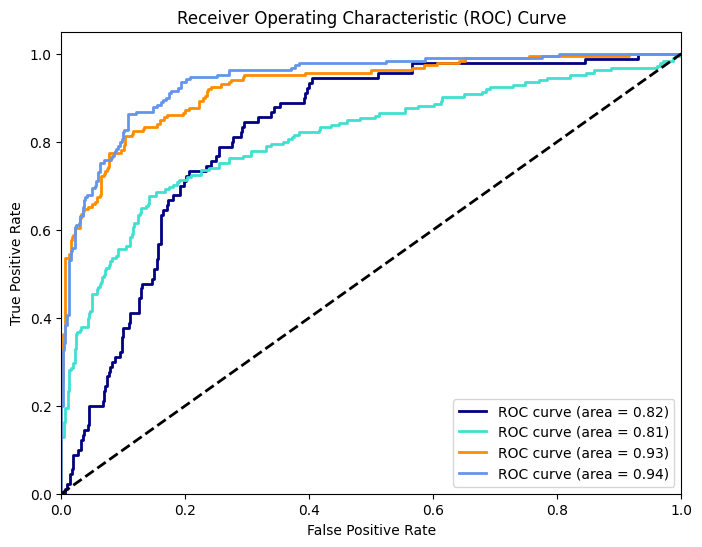

In [ ]:
for n in n_components:
    ada_svm = AdaBoostClassifier(base_estimator=SVC(probability=True, kernel='rbf'), n_estimators=10, random_state=42)
    ada_svm.fit(X_train[n], y_train[n])
    y_pred = ada_svm.predict(X_test[n])
    y_score = ada_svm.predict_proba(X_test[n])
    metrics(y_test[n],y_pred)
    plot_roc_curve(y_test[n],y_score)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.60
Confusion Matrix:
[[  4  43  35   8]
 [  0 122  59   4]
 [  0  31 154   2]
 [  2  36  44 108]]


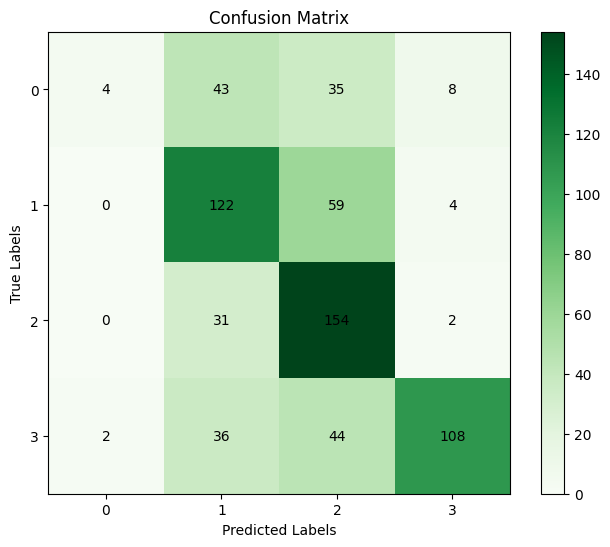

F1 score (macro): 0.50


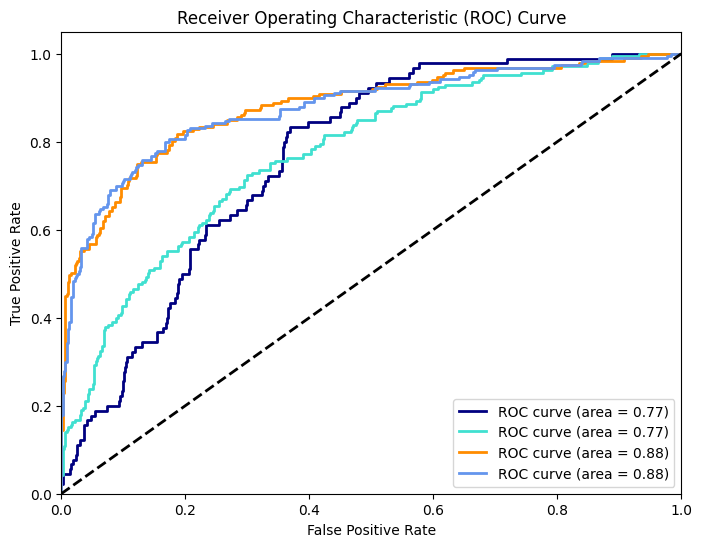

In [ ]:
ada_svm = AdaBoostClassifier(base_estimator=SVC(probability=True, kernel='rbf'), n_estimators=10, random_state=42)
ada_svm.fit(X_train_pso, y_train_pso)
y_pred = ada_svm.predict(X_test_pso)
y_score = ada_svm.predict_proba(X_test_pso)
metrics(y_test_pso,y_pred)
plot_roc_curve(y_test_pso,y_score)